# Prova Final - SuperComputação
---
🔥 Atenção: mude o runtime para GPU!




Edite a célula a seguir para inserir seu nome.
No blackboard, você vai submeter o arquivo .ipynb para correção. 


# 🆔 SEU NOME: Lívia Sayuri Makuta.



## Questão 1: Calculando um histograma de maneira distribuída (3 pontos).



O cálculo do histograma é um processo que envolve a contagem de ocorrências de valores em intervalos (bins) específicos. No caso do código fornecido abaixo, o cálculo do histograma deve realizado em paralelo utilizando o MPI (*Message Passing Interface*) para distribuir o processamento entre os nós de execução.

O programa recebe os seguintes parâmetros de entrada: `bin_count`, `min_meas`, `max_meas` e `data_count`. O `bin_count` representa o número de bins no histograma, ou seja, a quantidade de intervalos em que os valores serão divididos. O `min_meas` e `max_meas` indicam os limites inferior e superior, respectivamente, do intervalo de valores a ser considerado. O `data_count` é o número total de valores que serão gerados aleatoriamente.

No nó mestre, você deve complementar a implementação de modo que as  seguintes etapas sejam realizadas:
1. Geração dos dados aleatórios: o nó mestre é responsável por gerar os `data_count` valores aleatórios dentro do intervalo definido por `min_meas` e `max_meas`.

2. Distribuição dos dados: o nó mestre utiliza a função `MPI_Scatterv` para dividir os dados igualmente entre todos os nós de execução. **Documentação de MPI_Scatterv: https://www.mpi-forum.org/docs/mpi-1.1/mpi-11-html/node72.html** .

Nos nós de execução, cada nó realiza as seguintes etapas:

1. Recebimento dos dados: os nós de execução recebem os dados correspondentes ao seu intervalo do histograma por meio da função `MPI_Scatterv`.

2. Cálculo local do histograma: cada nó de execução computa a contagem de ocorrências de valores em seus dados locais, utilizando a função `compute_histogram`. Essa função recebe como parâmetros o `bin_count`, `data_per_process`, `loc_data` (dados locais do nó), `loc_bin_max` (intervalos dos bins correspondentes ao nó) e `loc_bin_sum` (vetor para armazenar a contagem de cada bin localmente).


Após o cálculo local do histograma nos nós de execução, é realizado o processo de **redução** dos resultados no nó mestre. Isso é feito por meio da função `MPI_Reduce`, que combina as contagens de cada bin de todos os nós e armazena o resultado final no vetor `histogram` no nó mestre. Por fim, o nó mestre imprime os valores do histograma final.

Dessa forma, o processamento no nó mestre envolve a geração dos dados aleatórios, a distribuição dos dados para os nós de execução e a impressão do resultado final. Já os nós de execução são responsáveis pelo recebimento dos dados, o cálculo local do histograma e a redução dos resultados no nó mestre.

Ao final da execução, deve ser retornado o tempo de execução total, em segundos, para que possamos criar um gráfico em Python que compare o tempo de execução em função da distribuição da execução em múltiplos nós.  Alguns códigos já estão prontos para você usar, para facilitar a sua implementação, mas fique à vontade para adapta-los como melhor julgar. 

In [ ]:
### ABAIXO TEMOS A DEFINIÇÃO DO CLUSTER QUE VAMOS USAR

In [15]:
%%writefile cluster.xml

<?xml version='1.0'?>
<!DOCTYPE platform SYSTEM "https://simgrid.org/simgrid.dtd">
<platform version="4.1">
  <zone id="world" routing="Full">
    <cluster id="cluster-crossbar"
             prefix="node-" radical="0-32" suffix=".simgrid.org"
	     speed="1Gf" bw="125MBps" lat="50us"/>
  </zone>
</platform>

Writing cluster.xml


In [16]:
### EXECUTE ESSA CÉLULA PARA INSTALAR O SIMGRID
!apt install simgrid --quiet

Reading package lists...
Building dependency tree...
Reading state information...
libsimgrid-dev is already the newest version (3.24+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [7]:
### FAÇA O CLONE DO REPOSITORIO DE TEMPLATES
!git clone https://framagit.org/simgrid/simgrid-template-smpi.git

Cloning into 'simgrid-template-smpi'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 482 (delta 180), reused 435 (delta 139), pack-reused 0
Receiving objects: 100% (482/482), 967.66 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [17]:
### MOVA NOSSA ESPECIFICACAO DE CLUSTER PARA A PASTA ADEQUADA
!mv cluster.xml simgrid-template-smpi/

A seguir você tem o esqueleto de um programa em C++ denominado `histograma.cpp` que você deve complementar para atender as especificações que detalhamos anteriormente.



In [45]:
%%writefile histograma.cpp

#include <iostream>
#include <vector>
#include <random>
#include <mpi.h>
using namespace std;

/* Função para gerar os dados. Essa função está pronta e você não precisa customiza-la.
*/
void generate_data(std::vector<float>& arr, long count, float min, float max) {
   //Verifica se os valores min e max sao validos
    if (max < min) {
        std::cout << "O valor de min deve ser menor que max....\nFinalizando execução." << std::endl;
        exit(1);
    }
    // Gera dados aleatórios
   
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_real_distribution<float> dis(min, max);

    for (int i = 0; i < count; i++) {
        float random_number = dis(gen);
        arr[i] = random_number;
    }
}

/*
 * Essa função calcula a quantidade de dados que 
 * ficarão em cada bin do histograma.
 * Função pronta. Observe que ela altera dados por referência!
 * */

void compute_histogram(long bin_count, long data_per_process, const std::vector<float>& loc_data,
                       const std::vector<float>& loc_bin_max, std::vector<long>& loc_bin_sum) {

    loc_bin_sum.resize(bin_count);
    for (int i = 0; i < bin_count; i++)
        loc_bin_sum[i] = 0;

    for (int i = 0; i < data_per_process; i++) {
        float data_value = loc_data[i];
        for (int j = 0; j < bin_count; j++) {
            // Se o valor é menor que bin_max, ele deve ser incluído
            if (data_value <= loc_bin_max[j]) {
                loc_bin_sum[j] += 1;
                break;
            }
        }
    }
}

int main(int argc, char* argv[]) {

    std::vector<float> data, bin_max, loc_data;
    std::vector<long> histogram, loc_histogram;
    int comm_sz, rank;
    float min_meas, max_meas, bin_width;
    long bin_count, data_count;
    long data_per_process;
    double start_total, finish_total;
    double start_app, finish_app;
    double start_histo, final_histo;

    //TO DO: Faça as devidas inicializações em MPI, e armazene os valores em comm_sz e rank

    MPI_Init(&argc, &argv);                 //Start MPI
    MPI_Comm_size(MPI_COMM_WORLD, &comm_sz);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);           //get rank of node's process

    // O processo 0 obtem todos os inputs e distribui os dados aos nós
    if (rank == 0) {
        bin_count = strtol(argv[1], NULL, 10);
        min_meas = strtof(argv[2], NULL);
        max_meas = strtof(argv[3], NULL);
        data_count = strtol(argv[4], NULL, 10);

        // Aloca a memória
        data.resize(data_count);
        bin_max.resize(bin_count);
        histogram.resize(bin_count);
        loc_histogram.resize(bin_count);
        //cout << "DATA RESIZE: " << data.size() << endl;
        //cout << "BIN MAX: " << bin_max.size() << endl;
        //cout << "BIN COUNT: " << histogram.size() << endl;

        // Gera os dados
       
        generate_data(data, data_count, min_meas, max_meas);

        //Abaixo calculamoso  tamanho de cada bin (bin_width) e o bin_max

        bin_width = (max_meas - min_meas) / (float)bin_count;
        float prev_bin_max = min_meas;
        for (int i = 0; i < bin_count; i++) {
            prev_bin_max = prev_bin_max + bin_width;
            bin_max[i] = prev_bin_max;
        }

        // Determina os dados a serem distribuídos aos nós
        data_per_process = data_count / comm_sz;
        loc_data.resize(data_per_process);


        //TO DO: Aqui você deve distribuir os dados adequadamente para cada nó.
        //Observe que você pode ter um último nó que recebe uma quantidade diferente
        //dos demais
        //Releia o enunciado e busque as funções que sugerimos que você utilize
        //Lembre-se que você pode tentar outras funções  que estejam disponíveis
        //na documentação do MPI que apresentamos em aula

        // Gerar offset e count:

        vector<int> count(comm_sz, data_per_process);
        vector<int> displacement(comm_sz);
        
        for (int i = 0; i < comm_sz - 1; i++){
          displacement[i+1] = displacement[i] + count[i];
        }

        MPI_Scatterv(data.data(), count.data(), displacement.data(), MPI_FLOAT, loc_data.data(), data_per_process, MPI_FLOAT, 0, MPI_COMM_WORLD);
        //MPI_Scatter(void* send_data, int send_count, MPI_Datatype send_datatype, void* recv_data, int recv_count, MPI_Datatype recv_datatype,int root,MPI_Comm communicator)

    }
    else {

        MPI_Scatterv(NULL, NULL, NULL, MPI_FLOAT, loc_data.data(), data_per_process, MPI_FLOAT, 0, MPI_COMM_WORLD);

    }   
    
    //TO DO: todos os nós calculam o histograma
    compute_histogram(bin_count, data_per_process, loc_data, bin_max, loc_histogram);
    
    //TO DO: você precisa fazer a redução para receber os dados 
     MPI_Reduce(&loc_histogram[0], &histogram[0], bin_count, MPI_LONG, MPI_SUM, 0, MPI_COMM_WORLD);

   
    if (rank == 0) {
        finish_total = MPI_Wtime();
        finish_app = finish_total;
        //O output abaixo é necessario para que possamos reportar no Python como um grafico
        std::cout   << finish_app - start_app;
    }
    MPI_Finalize();
    
    return 0;
}




Overwriting histograma.cpp


Compile o seu código

In [46]:
!smpicxx histograma.cpp -o hist

Execute a partir do exemplo abaixo. Veja que já estamos definindo os valores dos argumentos para você testar. De todo modo, você é livre para modificar esses parâmetros de modo a explorar o desempenho do programa.

In [48]:
!smpirun -np 1 -platform simgrid-template-smpi/cluster.xml -hostfile simgrid-template-smpi/cluster_hostfile --cfg=smpi/host-speed:1e9 ./hist 200 20 500 200000000

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/host-speed' to '1e9'
19.5466

In [47]:
!smpirun -np 2 -platform simgrid-template-smpi/cluster.xml -hostfile simgrid-template-smpi/cluster_hostfile --cfg=smpi/host-speed:1e9 ./hist 200 20 500 200000000

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/host-speed' to '1e9'
14.3891

Queremos que você produza um gráfico em Python comparando o desempenho em função da distribuição da computação em múltiplos nós. Para isso, deixamos pronta a função abaixo para que você execute. Lembre-se que fizemos algo similar na aula 1. 

In [49]:
import subprocess

def executa_comando(np):
# Comando para executar o programa C++ com smpirun
  execute_command = [
    'smpirun', '-np', np, '-platform', 'simgrid-template-smpi/cluster.xml',
    '-hostfile', 'simgrid-template-smpi/cluster_hostfile', '--cfg=smpi/host-speed:1e9',
    './hist', '200', '20', '500', '200000000'
  ]

  # Executar o comando
  process = subprocess.run(execute_command, capture_output = True)
  return float(process.stdout)


In [50]:
# aqui temos os valores de -np que queremos que você teste
nps = ['1', '2', '4', '8', '12', '16', '32']

In [51]:
# aqui acontece a execução. Lembre-se que seu programa deve ter um único output, que é o tempo em segundos 
tempos = [executa_comando(np) for np in nps]

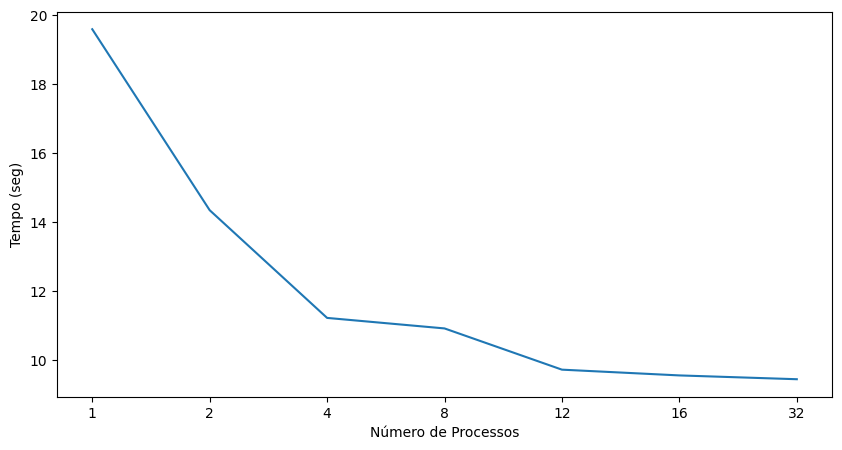

In [52]:
### Use o código abaixo para plotar seu resultado
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('Número de Processos')
ax.set_ylabel('Tempo (seg)')
ax.plot(nps, tempos)
plt.show()

> ✋ **AVALIE A EXECUÇÃO DE SEU CÓDIGO.**: Como o programa se comportou com a distribuição dos processos?

Como pode ser visto por meio do gráfico, o programa se comportou bem com a distribuição dos processos, principalmente no intervalo de 1 para 12 slaves, em que o tempo de execução diminuiu bastante, indicando que a paralelização do cluster funcionou. Ou seja, essa distribuição da carga de trabalho entre as várias máquinas foi eficiente e fez com que cada uma pudesse processar uma porção menor dos dados. 

Entretanto, a partir de 12 processos, o tempo de execução praticamente estagnou. Isso porque chega um ponto em que há muitos recursos para a entrada definida. No MPI, assim como para outras ferramentas de paralelização, há um tempo necessário para alocar os recursos e , nesse caso, para que as máquinas do cluster enviem os dados e se comuniquem. Esse tempo deixa de compensar a partir do momento em que os dados a serem processados não exigem tantos processos para que a execução seja eficiente. 

Como melhorias, para otimizar o desempenho do nosso programa em MPI, poderíamos experimentar diferentes configurações, como aumentar a quantidade de dados, ajustar o número de bins do histograma ou modificar a lógica do cálculo do histograma para aumentar a carga de trabalho por processo (para valer a pena ter mais processos). 


---
# Questão 2 (1 ponto):



Modifique a resolução da questão anterior, de modo que a função `compute_histogram` seja calculada com Threads em OpenMP. 

In [69]:
%%writefile histograma_paralelizado.cpp

#include <iostream>
#include <vector>
#include <random>
#include <mpi.h>
#include <omp.h>
using namespace std;

/* Função para gerar os dados. Essa função está pronta e você não precisa customiza-la.
*/
void generate_data(std::vector<float>& arr, long count, float min, float max) {
   //Verifica se os valores min e max sao validos
    if (max < min) {
        std::cout << "O valor de min deve ser menor que max....\nFinalizando execução." << std::endl;
        exit(1);
    }
    // Gera dados aleatórios
   
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_real_distribution<float> dis(min, max);

    for (int i = 0; i < count; i++) {
        float random_number = dis(gen);
        arr[i] = random_number;
    }
}

/*
 * Essa função calcula a quantidade de dados que 
 * ficarão em cada bin do histograma.
 * Função pronta. Observe que ela altera dados por referência!
 * */

void compute_histogram(long bin_count, long data_per_process, const std::vector<float>& loc_data,
                       const std::vector<float>& loc_bin_max, std::vector<long>& loc_bin_sum) {
    loc_bin_sum.resize(bin_count);

    for (int i = 0; i < bin_count; i++)
        loc_bin_sum[i] = 0;

    #pragma omp parallel for
    for (int i = 0; i < data_per_process; i++) {
        float data_value = loc_data[i];
        for (int j = 0; j < bin_count; j++) {
            // Se o valor é menor que bin_max, ele deve ser incluído
            if (data_value <= loc_bin_max[j]) {
              #pragma omp critical
                loc_bin_sum[j] += 1;
                break;
            }
        }
    }
}


int main(int argc, char* argv[]) {
    std::vector<float> data, bin_max, loc_data;
    std::vector<long> histogram, loc_histogram;
    int comm_sz, rank;
    float min_meas, max_meas, bin_width;
    long bin_count, data_count;
    long data_per_process;
    double start_total, finish_total;
    double start_app, finish_app;
    double start_histo, final_histo;

    //TO DO: Faça as devidas inicializações em MPI, e armazene os valores em comm_sz e rank

    MPI_Init(&argc, &argv);                 //Start MPI
    MPI_Comm_size(MPI_COMM_WORLD, &comm_sz);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);           //get rank of node's process

    // O processo 0 obtem todos os inputs e distribui os dados aos nós
    if (rank == 0) {
        bin_count = strtol(argv[1], NULL, 10);
        min_meas = strtof(argv[2], NULL);
        max_meas = strtof(argv[3], NULL);
        data_count = strtol(argv[4], NULL, 10);

        // Aloca a memória
        data.resize(data_count);
        bin_max.resize(bin_count);
        histogram.resize(bin_count);
        loc_histogram.resize(bin_count);
        //cout << "DATA RESIZE: " << data.size() << endl;
        //cout << "BIN MAX: " << bin_max.size() << endl;
        //cout << "BIN COUNT: " << histogram.size() << endl;

        // Gera os dados
       
        generate_data(data, data_count, min_meas, max_meas);

        //Abaixo calculamoso  tamanho de cada bin (bin_width) e o bin_max

        bin_width = (max_meas - min_meas) / (float)bin_count;
        float prev_bin_max = min_meas;
        for (int i = 0; i < bin_count; i++) {
            prev_bin_max = prev_bin_max + bin_width;
            bin_max[i] = prev_bin_max;
        }

        // Determina os dados a serem distribuídos aos nós
        data_per_process = data_count / comm_sz;
        loc_data.resize(data_per_process);


        //TO DO: Aqui você deve distribuir os dados adequadamente para cada nó.
        //Observe que você pode ter um último nó que recebe uma quantidade diferente
        //dos demais
        //Releia o enunciado e busque as funções que sugerimos que você utilize
        //Lembre-se que você pode tentar outras funções  que estejam disponíveis
        //na documentação do MPI que apresentamos em aula

        // Gerar offset e count:

        vector<int> count(comm_sz, data_per_process);
        vector<int> displacement(comm_sz);
        
        for (int i = 0; i < comm_sz - 1; i++){
          displacement[i+1] = displacement[i] + count[i];
        }

        MPI_Scatterv(data.data(), count.data(), displacement.data(), MPI_FLOAT, loc_data.data(), data_per_process, MPI_FLOAT, 0, MPI_COMM_WORLD);
        //MPI_Scatter(&data[0], data_per_process, data_per_process*sizeof(float), MPI_FLOAT, loc_data.data(), data_per_process, MPI_FLOAT, 0, MPI_COMM_WORLD);

    }
    else {

        MPI_Scatterv(NULL, NULL, NULL, MPI_FLOAT, loc_data.data(), data_per_process, MPI_FLOAT, 0, MPI_COMM_WORLD);

    }   
    
    //TO DO: todos os nós calculam o histograma
    compute_histogram(bin_count, data_per_process, loc_data, bin_max, loc_histogram);
    
    //TO DO: você precisa fazer a redução para receber os dados 
     MPI_Reduce(&loc_histogram[0], &histogram[0], bin_count, MPI_LONG, MPI_SUM, 0, MPI_COMM_WORLD);

   
    if (rank == 0) {
        finish_total = MPI_Wtime();
        finish_app = finish_total;
        //O output abaixo é necessario para que possamos reportar no Python como um grafico
        std::cout   << finish_app - start_app;
    }
    MPI_Finalize();
    
    return 0;
}


Overwriting histograma_paralelizado.cpp


In [70]:
!smpicxx -fopenmp histograma_paralelizado.cpp -o hist_paralelo

In [71]:
!smpirun -np 2 -platform simgrid-template-smpi/cluster.xml -hostfile simgrid-template-smpi/cluster_hostfile --cfg=smpi/host-speed:1e9 ./hist_paralelo 200 20 500 200000000

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/host-speed' to '1e9'
7.87367

Como pôde ser visto no código anterior, a paralelização foi feita com o  `#pragma omp parallel for`, que indica que o loop deve ser executado em paralelo. Essa diretiva cria um grupo de threads e divide automaticamente as iterações do loop entre as threads disponíveis - nesse caso como a princípio não defini nenhuma, o código criou um número de threads padrão no ambiente do Colab. E isso foi possível, pois os dados não possuem dependência entre as iterações.

Por sua vez, dentro do loop paralelo, cada thread executa uma parte do processamento, sendo que a variável i é compartilhada entre as threads, e cada uma delas é responsável por uma parte diferente do intervalo [0, data_per_process]. Porém, uma variável é acessada e modificada por todas as threads: `loc_bin_sum[j]`, sendo assim, é importante garantir que o acesso a ela seja realizado de forma segura. Por isso, a diretiva `#pragma omp critical` foi usada para criar uma região crítica, onde apenas uma thread pode executar por vez, evitando conflitos.

Com o código implementado, resolvi testar o tempo de execução para diferentes números de processos e com o número de threads fixo para cada execução, o que gerou os gráficos a seguir:

In [73]:
import subprocess
import os

def executa_comando(np, num_threads):
  os.environ['OMP_NUM_THREADS'] = str(num_threads)
# Comando para executar o programa C++ com smpirun
  execute_command = [
    'smpirun', '-np', np, '-platform', 'simgrid-template-smpi/cluster.xml',
    '-hostfile', 'simgrid-template-smpi/cluster_hostfile', '--cfg=smpi/host-speed:1e9',
    './hist_paralelo', '200', '20', '500', '200000000'
  ]

  # Executar o comando
  process = subprocess.run(execute_command, capture_output = True)
  return float(process.stdout)


In [74]:
nps_parallel = ['1', '2', '4', '8', '12', '16', '32']

In [75]:
tempos_parallel_2 = [executa_comando(np, 2) for np in nps]

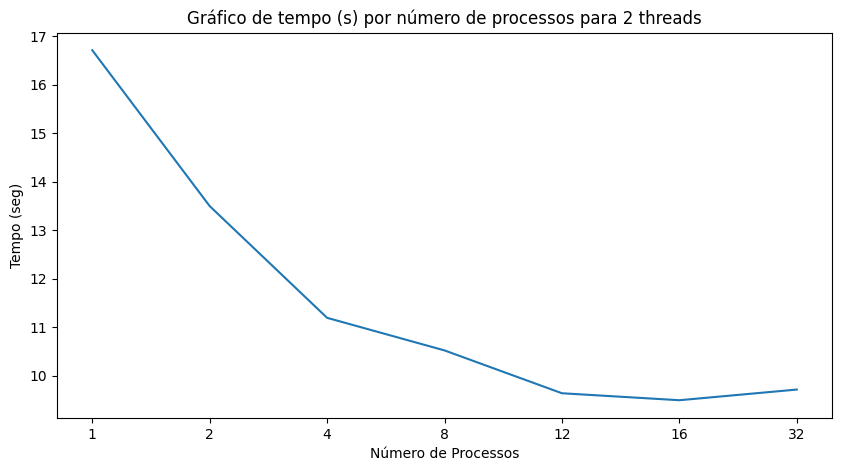

In [77]:
### Use o código abaixo para plotar seu resultado
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Gráfico de tempo (s) por número de processos para 2 threads')
ax.set_xlabel('Número de Processos')
ax.set_ylabel('Tempo (seg)')
ax.plot(nps_parallel, tempos_parallel_2)
plt.show()

Para o primeiro caso, com o número de threads fixo em 2, podemos notar que a diminuição de tempo não foi muito grande, de tal forma que no teste com 32 processos o tempo começou a aumentar novamente, ou seja, chegou em um ponto em que o número de processos já passou a ser desnecessário para a entrada passada.

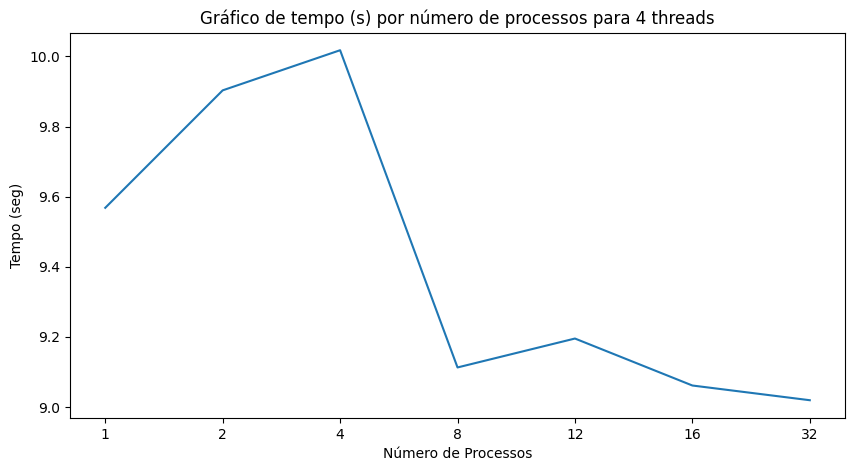

In [78]:
tempos_parallel_4 = [executa_comando(np, 4) for np in nps]

### Use o código abaixo para plotar seu resultado
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Gráfico de tempo (s) por número de processos para 4 threads')
ax.set_xlabel('Número de Processos')
ax.set_ylabel('Tempo (seg)')
ax.plot(nps_parallel, tempos_parallel_4)
plt.show()

Para o segundo caso, com o número de threads fixo em 4, podemos notar que o tempo de execução diminuiu bastante, porém chegou a aumentar para o caso que o número de máquinas era de 2 e 4. Isso provavelmente porque a paralelização ainda não era suficiente para a quantidade dos dados, pois para paralelizar com OpenMP e MPI, existe um processo de coordenação e comunicação de processos e máquinas, e nesse caso, utilizar essas duas formas de paralelização mas em pequena quantidade talvez não seja muito proveitoso. 

Por outro lado, quando o número de máquinas aumenta, é possível que haja um benefício maior da paralelização em MPI. Como dito antes, isso deve estar acontecendo por conta da relação de tamanho da carga de trabalho e a quantidade de dados processados por cada máquina, pois com um número maior de máquinas, cada uma processa uma quantidade menor de dados, o que pode levar a uma distribuição mais equilibrada do trabalho e a uma redução no tempo de execução.

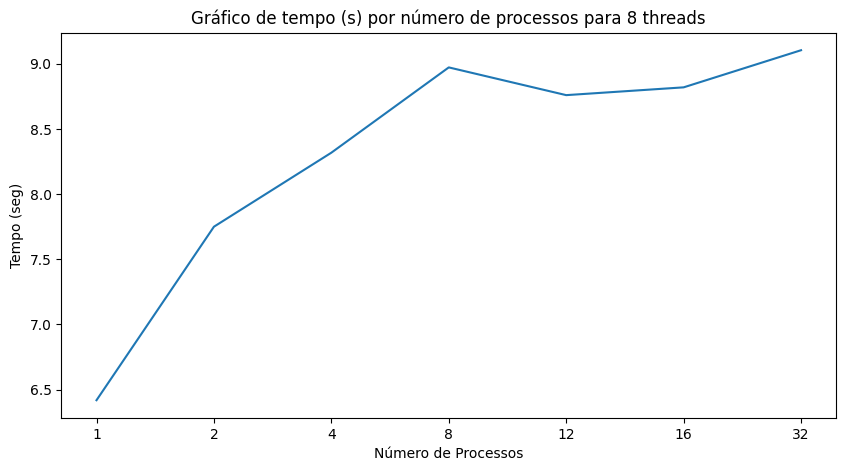

In [80]:
tempos_parallel_8 = [executa_comando(np, 8) for np in nps]

### Use o código abaixo para plotar seu resultado
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Gráfico de tempo (s) por número de processos para 8 threads')
ax.set_xlabel('Número de Processos')
ax.set_ylabel('Tempo (seg)')
ax.plot(nps_parallel, tempos_parallel_8)
plt.show()

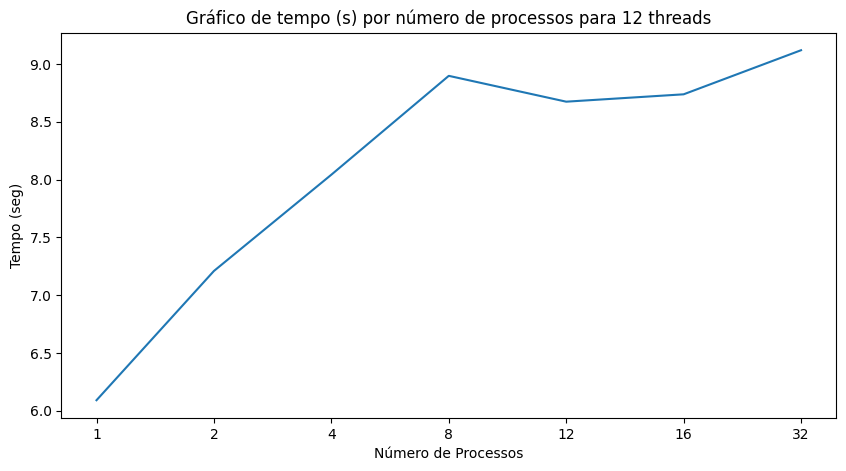

In [81]:
tempos_parallel_12 = [executa_comando(np, 12) for np in nps]

### Use o código abaixo para plotar seu resultado
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Gráfico de tempo (s) por número de processos para 12 threads')
ax.set_xlabel('Número de Processos')
ax.set_ylabel('Tempo (seg)')
ax.plot(nps_parallel, tempos_parallel_12)
plt.show()

Por fim, os gráficos para 8 e 12 threads ficaram bem similares. No ínicio, para apenas uma máquina apresentaram um bom desempenho, mas conforme o número delas foi subindo, o tempo de execução começou a aumentar. Isso porque quando aumentamos o número de threads para um valor alto e ao mesmo tempo aumentamos o número de máquinas, pode ocorrer um aumento no tempo de execução devido a sobrecarga de comunicação, concorrência de recursos e diminuição do paralelismo do programa em si. 

Além disso, vale lembrar que pode depender também do ambiente de execução, que pode limitar o número de threads máximo a ser criado e fixá-lo caso tentem ser criadas mais threads do que o permitido. Logo, pode ser que para as últimas threads a quantidade pedida nem tenha sido criada e tenha sido apenas limitada ao número máximo permitido pelo Colab.

Em resumo, para a paralelização ser eficiente precisamos escolher o número de máquinas e threads de acordo com o tamanho da carga de trabalho, da quantidade de dados e do equilíbrio entre a sobrecarga de comunicação e a melhoria no desempenho obtida pela paralelização. 

---
# Questão 3 (2 pontos)




Você trabalha em uma empresa de processamento de dados que precisa analisar grandes volumes de informações para identificar tendências. Recentemente, a empresa adquiriu uma placa gráfica de alto desempenho para acelerar essas análises. No entanto, você percebeu que o processamento desses dados ainda está levando mais tempo do que o esperado, devido à complexidade das operações envolvidas. Sua tarefa é otimizar o código existente para aproveitar a capacidade de processamento da GPU utilizando a biblioteca **Thrust**.

Você recebeu um conjunto de dados em forma de vetor, contendo números inteiros positivos. Sua tarefa é encontrar a soma dos quadrados dos números pares no vetor utilizando a operação de fusão com a função **transform_reduce** ❗ da biblioteca Thrust, aproveitando o poder de processamento da GPU.

Instruções:

1. Importe a biblioteca Thrust e outras bibliotecas necessárias.
2. Defina uma função de transformação que receba um número inteiro e retorne o seu quadrado se ele for par, caso contrário, retorna 0.
3. Crie um vetor na memória da GPU com os dados fornecidos.
4. Utilize a função transform_reduce do Thrust para realizar a fusão dos elementos do vetor, aplicando a função de transformação e soma necessárias.
5. Imprima o resultado da soma dos quadrados dos números pares.



In [13]:
%%writefile resolucao_3.cu

#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/transform_reduce.h>
#include <thrust/functional.h>
#include <thrust/transform.h>
#include <thrust/random.h>
#include <iostream>
#include <fstream>
#include <iomanip>
#include <cstdlib>
#include <chrono>
#include <cstdlib>
#include <algorithm>
#include <cmath>
#include <random>
using namespace std; 

struct QuadradoPares  {
    __host__ __device__
    int operator()(int x) const {
        if (x % 2 == 0)
            return x * x;
        else
            return 0;
    }
};

int main(){

  thrust::host_vector<int> h_data(11);
  thrust::sequence(h_data.begin(), h_data.end());

  //for (int i = 0; i < 10; i++){
  //  cout << h_data[i];
  //}

  // Cria um vetor na memória da GPU e copia os dados para ele
  thrust::device_vector<int> d_data(h_data);

  // Utiliza a função transform_reduce para realizar a fusão dos elementos do vetor
  int sum = thrust::transform_reduce(d_data.begin(), d_data.end(), QuadradoPares(), 0, thrust::plus<int>());

  std::cout << "Soma dos quadrados dos números pares: " << sum << std::endl;

  return 0;
}

Overwriting resolucao_3.cu


Para compilar seu código, faça uso do comando abaixo. No caso `resolucao_3.cu` é seu arquivo de código-fonte.

In [14]:
!nvcc -arch=sm_75 -std=c++14 resolucao_3.cu -o resolucao

In [15]:
!./resolucao

Soma dos quadrados dos números pares: 220


A implementação do código seguiu os passos definidos no enunciado. Além disso, o teste foi feito para 11 números inteiros positivos em uma sequência que começa em 0 e que incrementa 1 até chegar no número de elementos.

Nesse caso, o vetor de entrada foi:

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

Sendo assim, a soma dos quadrados dos números pares devia ser:

O^2 + 2^2 + 4^2 + 6^2 + 8^2 + 10^2 = 4 + 16 + 36 + 64 + 100 = 220.




---
# Questão 4 (2 pontos)



Considere o seguinte trecho de código em C++ que utiliza threads em OpenMP:

```cpp
#include <iostream>
#include <omp.h>

int main() {
    int count = 0;

    #pragma omp parallel num_threads(4)
    {
        #pragma omp critical
        {
            count++;
        }
    }

    std::cout << "O valor de count é: " << count << std::endl;

    return 0;
}
```

1. Explique o papel do bloco de diretivas `#pragma omp parallel` neste código. Como as threads são criadas e como elas são distribuídas entre os processadores? (0,5 ponto)

2. Descreva o significado e o papel da diretiva `#pragma omp critical` no contexto do código fornecido. Explique o que acontece quando várias threads tentam executar a região crítica simultaneamente. (1 ponto)

3. O que é uma região crítica e por que é importante protegê-la? Como a diretiva `#pragma omp critical` ajuda a garantir a exclusão mútua nesse caso? (0,5 ponto)

1) **R:** O bloco de diretivas `#pragma omp parallel` faz uma paralelização em que múltiplas threads podem executar de forma simultânea. No caso, essa região que foi paralelizada é definida com `num_threads(4)`, indicando que devem ser criadas quatro threads para executar o bloco de código seguinte.


A forma como as threads são criadas e distribuídas entre os processadores é determinada pela implementação do OpenMP e pelas configurações do sistema. Geralmente, as threads são distribuídas de forma equilibrada pelos processadores disponíveis, permitindo uma execução eficiente e paralela. Mas a ordem em que as threads vão rodar, quem irá executar o bloco de código primeiro, não é possível saber, apenas se sabe que 4 threads serão criadas e atuarão no código para paralelizá-lo. 


2) **R:** A diretiva `#pragma omp critical` define uma região crítica no código, o que indica que só uma thread pode executar essa região por vez. Sendo assim, quando uma thread entra na região crítica, ainda que todas as outras threads tentem entrar naquela região ao mesmo tempo, elas terão que esperar até que a thread que entrou ali termine a execução dessa região para poder continuarem. O conceito de região crítica é similar ao de um semáforo, que aprendemos na disciplina de Sistemas Hardware Software e de Computação Embarcada, onde um recurso é compartilhado entre várias threads e precisa ser acessado de forma exclusiva para garantir a consistência dos resultados.

3) **R:** Uma região crítica é uma seção do código em que uma ou mais threads vão acessar recursos compartilhados, como variáveis e vetores, o que pode causar problemas de concorrência e inconsistências se forem acessados simultaneamente. Sendo assim, é importante proteger uma região crítica para garantir que apenas uma thread possa executar a região crítica por vez.

Além disso, a diretiva `#pragma omp critical` pode ajudar nisso, já que ela garante a exclusão mútua na região crítica ao permitir que apenas uma thread execute essa região por vez. Assim, quando várias threads tentam executar a região crítica ao mesmo tempo, aquelas que não conseguem entrar na região crítica ficam em espera até que a thread que está executando a região crítica termine. Dessa forma, problemas de acesso concorrente são evitados e é garantido que o recurso compartilhado vai ser acessado corretamente.

---
# Questão 5 (2 pontos)



## Simulação de Colisão de Partículas

![](https://scipython.com/static/media/uploads/blog/collision/collision-img.gif)

A simulação de colisão de partículas desempenha um papel crucial em diversas áreas da ciência e engenharia. Ela permite estudar e compreender o comportamento e a interação de partículas em sistemas físicos complexos, como gases, líquidos, materiais granulares, entre outros. Essa simulação é particularmente valiosa quando a observação direta desses sistemas é difícil ou impraticável. Ao simular as colisões entre as partículas, é possível obter informações sobre a distribuição de velocidades, padrões de movimento coletivo, propriedades termodinâmicas, dissipação de energia e outras características relevantes para o sistema em estudo. Essa abordagem computacional é amplamente utilizada em áreas como física, química, biologia, engenharia de materiais e ciência da computação.

No contexto da detecção de colisão de partículas em paredes, uma abordagem comum é verificar se a partícula ultrapassou os limites da área de simulação. Isso é feito comparando as coordenadas x e y da partícula com os limites inferior (geralmente 0) e superior (geralmente 1) da área. Se a partícula estiver além desses limites, ocorreu uma colisão com a parede correspondente.

Para reverter a direção da partícula e simular o rebote na parede, a lógica empregada é simples: se a partícula ultrapassar um dos limites, inverte-se o sinal da componente de velocidade correspondente. Por exemplo, se a partícula atingir o limite superior, a velocidade em y é invertida, fazendo com que a partícula mude de direção verticalmente. Essa inversão de velocidade é análoga a uma colisão elástica, onde a partícula rebota na parede sem perda de energia cinética.

Dessa forma, a detecção de colisões com as paredes e a inversão da velocidade permitem que as partículas simulem o comportamento de colisão com obstáculos físicos, permitindo investigar como as partículas interagem com seu ambiente e como isso afeta a dinâmica geral do sistema em estudo.

O código abaixo é uma implementação para a simulação da colisão de particulas. Sua tarefa é simples:

1. Adapte a função detectCollisions para ser paralelizada por openMP (pode ser um `parallel for`, `section` ou `task`). 

2. Execute o programa múltiplas vezes mudando o número de threads (você pode fazer isso executando `export OMP_NUM_THREADS=xx` no sistema operacional, onde xx é o número de threads que você deseja).

3. Elabore um gráfico em Python que apresenta a evolução do tempo de execução conforme você aumenta o número de threads (simule para 1, 2, 4, 8 e 12)

4. Comente o speed up que você obteve (ou não!) ao incremento do número de threads.



In [1]:
%%writefile particulas.cpp

#include <iostream>
#include <vector>
#include <cmath>
#include <cstdlib>
#include <ctime>
#include <omp.h>

struct Particle {
    double x, y;
    double velocityX, velocityY;
};

const int numParticles = 1000;
const int numIterations = 10000;
const double collisionDistance = 0.01;

void initializeParticles(std::vector<Particle>& particles) {
    std::srand(static_cast<unsigned int>(std::time(nullptr)));
    for (int i = 0; i < numParticles; ++i) {
        Particle p;
        p.x = static_cast<double>(std::rand()) / RAND_MAX;
        p.y = static_cast<double>(std::rand()) / RAND_MAX;
        p.velocityX = static_cast<double>(std::rand()) / RAND_MAX / 100.0;
        p.velocityY = static_cast<double>(std::rand()) / RAND_MAX / 100.0;
        particles.push_back(p);
    }
}

void updateParticle(Particle& particle) {
    particle.x += particle.velocityX;
    particle.y += particle.velocityY;
    if (particle.x < 0.0 || particle.x > 1.0)
        particle.velocityX = -particle.velocityX;
    if (particle.y < 0.0 || particle.y > 1.0)
        particle.velocityY = -particle.velocityY;
}

void detectCollisions(std::vector<Particle>& particles) {
    #pragma omp parallel for
    for (int i = 0; i < numParticles; ++i) {
        for (int j = i + 1; j < numParticles; ++j) {
            double dx = particles[i].x - particles[j].x;
            double dy = particles[i].y - particles[j].y;
            double distance = std::sqrt(dx * dx + dy * dy);
            if (distance < collisionDistance) {
                // Simulate collision by swapping velocities
                std::swap(particles[i].velocityX, particles[j].velocityX);
                std::swap(particles[i].velocityY, particles[j].velocityY);
            }
        }
    }
}

int main() {
    std::vector<Particle> particles;
    initializeParticles(particles);

    double startTime = omp_get_wtime();

    for (int iteration = 0; iteration < numIterations; ++iteration) {
        updateParticle(particles[iteration % numParticles]);
        detectCollisions(particles);
    }

    double endTime = omp_get_wtime();
    double executionTime = endTime - startTime;

    std::cout << "Execution time: " << executionTime << std::endl; // em segundos

    return 0;
}


Writing particulas.cpp


In [2]:
!g++ -fopenmp particulas.cpp -o particulas

In [24]:
!./particulas

Execution time: 93.9029 seconds


In [26]:
!export OMP_NUM_THREADS=4
!./particulas

Execution time: 94.7488 seconds


In [27]:
!export OMP_NUM_THREADS=8
!./particulas

Execution time: 93.6483 seconds


Tempo de execução para 1 threads: 112.894
Tempo de execução para 2 threads: 118.35
Tempo de execução para 4 threads: 95.0816
Tempo de execução para 8 threads: 92.6794
Tempo de execução para 12 threads: 92.4746


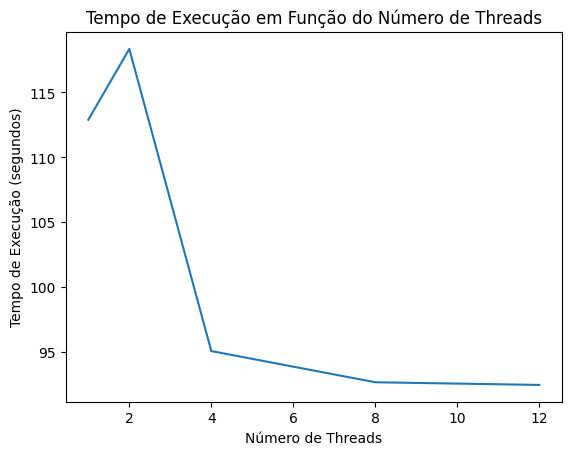

In [3]:
### Faça um gráfico e avalie o desempenho

import os
import subprocess
import matplotlib.pyplot as plt

def executa_programa(num_threads):
    os.environ['OMP_NUM_THREADS'] = str(num_threads)
    result = subprocess.run(['./particulas'], capture_output=True, text=True)
    output = result.stdout.strip()
    
    tempo_execucao = float(output.split(': ')[-1])
    return tempo_execucao

num_threads = [1, 2, 4, 8, 12]
tempos_execucao = []

for threads in num_threads:
    tempo = executa_programa(threads)
    tempos_execucao.append(tempo)
    print("Tempo de execução para", threads, "threads:", tempo)

# Código para plotar o gráfico
plt.plot(num_threads, tempos_execucao)
plt.xlabel('Número de Threads')
plt.ylabel('Tempo de Execução (segundos)')
plt.title('Tempo de Execução em Função do Número de Threads')
plt.show()



Para paralelizar a função utilizei apenas o `omp parallel for` pois cada iteração do loop é independente uma da outra, sendo assim, é possível que cada thread execute as diferentes iterações em paralelo de forma a dividir o trabalho entre as threads criadas.

Optei por não usar tarefas (`tasks`) pois as tarefas normalmente são usadas quando existem diferentes funções em que não importa a ordem em que elas sejam executadas. No caso do código das partículas, as iterações do loop são independentes não havendo dependências entre elas, mas não são funções, são um conjunto de passos sequenciais em que algumas operações como o cálculo do distance dependem do cálculo de dx e dy. Sendo assim, o `parallel for` parece ser mais simples e eficiente.

Em relação ao gráfico plotado (que executei algumas vezes para garantir que os resultados se repetiam), podemos notar que ocorreu um pico no tempo para o caso em que apenas duas threads foram utilizadas. Creio que este aconteceu porque nesse caso o paralelismo com 2 threads não deve ter sido suficiente, já que o tempo para criar e gerenciá-las deve ter se somado à pouca eficiência da paralelização que resulltou em uma piora no tempo de execução.

A partir de 4 threads os tempos de execução melhoraram bastante até chegar em 8 threads - saíram de aproximadamente 112 segundos para 95 segundos - indicando que a paralelização foi eficiente. Entretanto, de 8 até 12 threads o tempo de execução foi muito parecido, ou seja, o speedup praticamente não melhorou. Isso provavelmente se deve ao fato de que a partir de 8 threads o tempo de criação e gerenciamento delas está começando a influenciar bastante e demorando mais do que a execução do código em si. Além disso, vale lembrar que pode depender também do ambiente de execução, que pode limitar o número de threads máximo a ser criado e fixá-lo caso tentem ser criadas mais threads do que o permitido. 

Logo, conclui-se que a paralelização com threads de fato melhorou o tempo de execução - como pode ser visto no gráfico, ele apresentou uma grande queda. No entanto, a partir de um determinado ponto (no caso, a partir de 8 threads), o tempo de criação e gerenciamento das threads começa a ter um impacto significativo no tempo total de execução. Provavelmente, se fossem testadas com mais threads os tempos de execução piorariam a ponto da sobrecarga de sincronização e comunicação entre as threads superar os benefícios do paralelismo.



EOF (End of file)